### First model - Naive Bayes

In [33]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /home/milica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/milica/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Text processing functions

In [34]:
def preprocess_text(text: str):
    '''
    This function preprocesses the input text by performing the following steps:
    1. Removes stopwords except for "n't", "not", and "no".
    2. Removes 'br' tags from the text.
    3. Cleans the text by removing all punctuation, numbers, and special symbols.
    4. Lemmatizes the text by reducing each word to its base form.

    Parameters
    ----------
    text : (str)
        The input text to be preprocessed.

    Returns
    -------
    (str): The preprocessed text.
    '''
    
    def remove_stopwords(text: str):
        '''
        This function removes English stopwords from the input text.
        
        Parameters
        -----------
        text : (str) 
            Input text.
        
        Returns
        -------
        (str): Filtered text without stopwords.
        '''
        stopwords_list = stopwords.words('english')
        whitelist = ["n't", "not", "no"]
        words = text.split()
        filtered_text = [word for word in words if (word not in stopwords_list or word in whitelist)]
        return ' '.join(filtered_text)

    def remove_breaklines(text: str):
        '''
        This function removes 'br' from the input text.
        
        Parameters
        -----------
        text : (str) 
            Input text.
        
        Returns
        -------
        (str): Filtered text without 'br'.
        '''
        words = text.split()
        filtered_text = [word.replace('br', '') for word in words]
        return ' '.join(filtered_text)

    def clean_text(text: str):
        '''
        Cleans the input text by removing all punctuation, numbers, and special symbols,
        leaving only alphabetic characters and whitespace.
        
        Parameters
        ----------
        text : (str) 
            The input string to be cleaned.
        
        Returns
        -------
        (str): The cleaned string with only alphabetic characters and whitespace.
        '''
        pattern = r'[^a-zA-Z\s]'
        return re.sub(pattern, ' ', text)

    def lemmatize(text: str):
        '''
        This function lemmatizes the input text by reducing each word to its base form (lemma).
        
        Parameters
        ----------
        text : (str) 
            The input text to be lemmatized.
        
        Returns
        -------
        (str): The lemmatized text where each word is reduced to its base form.
        '''
        lemmatizer = WordNetLemmatizer()
        words = text.split()
        lemmatized_words = [lemmatizer.lemmatize(word, wordnet.VERB) for word in words]
        return ' '.join(lemmatized_words)


    text = remove_stopwords(text)
    text = remove_breaklines(text)
    text = clean_text(text)
    text = lemmatize(text)
    
    return text

### Data importing function

In [35]:
def load_data_from_folder(folder_path):
    '''
    This function loads text data from a folder where each subfolder represents a category.
    Each subfolder contains text files corresponding to that category.

    Parameters
    ----------
    folder_path : (str)
        The path to the folder containing the dataset.

    Returns
    -------
    data : (list)
        A list of texts.
    target : (list)
        A list of labels corresponding to each text.
    target_names : (list)
        A list of category names.
    '''
    data = []
    target = []
    target_names = os.listdir(folder_path)
    target_names.sort()  
    label_map = {name: idx for idx, name in enumerate(target_names)}

    for category in target_names:
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for file_name in os.listdir(category_path):
                file_path = os.path.join(category_path, file_name)
                if os.path.isfile(file_path):
                    with open(file_path, 'r', encoding='latin1') as file:
                        text = file.read()
                        text = preprocess_text(text)  
                        data.append(text)
                        target.append(label_map[category])

    return data, target, target_names

### Data import and train - test split

In [36]:
folder_path = '../datasets/20_newsgroups'

X, y, target_names = load_data_from_folder(folder_path)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Model training

In [38]:
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

MultinomialNB()

### Metrics

In [39]:
y_pred = clf.predict(X_test_tfidf)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

                          precision    recall  f1-score   support

             alt.atheism       0.76      0.84      0.80       173
           comp.graphics       0.81      0.83      0.82       179
 comp.os.ms-windows.misc       0.92      0.92      0.92       226
comp.sys.ibm.pc.hardware       0.81      0.89      0.85       204
   comp.sys.mac.hardware       0.94      0.93      0.93       205
          comp.windows.x       0.92      0.85      0.89       186
            misc.forsale       0.91      0.86      0.88       190
               rec.autos       0.92      0.92      0.92       203
         rec.motorcycles       0.97      0.93      0.95       218
      rec.sport.baseball       0.95      0.93      0.94       192
        rec.sport.hockey       0.93      0.97      0.95       203
               sci.crypt       0.94      0.97      0.96       200
         sci.electronics       0.95      0.84      0.89       227
                 sci.med       0.99      0.93      0.96       196
         

### The confusion matrix

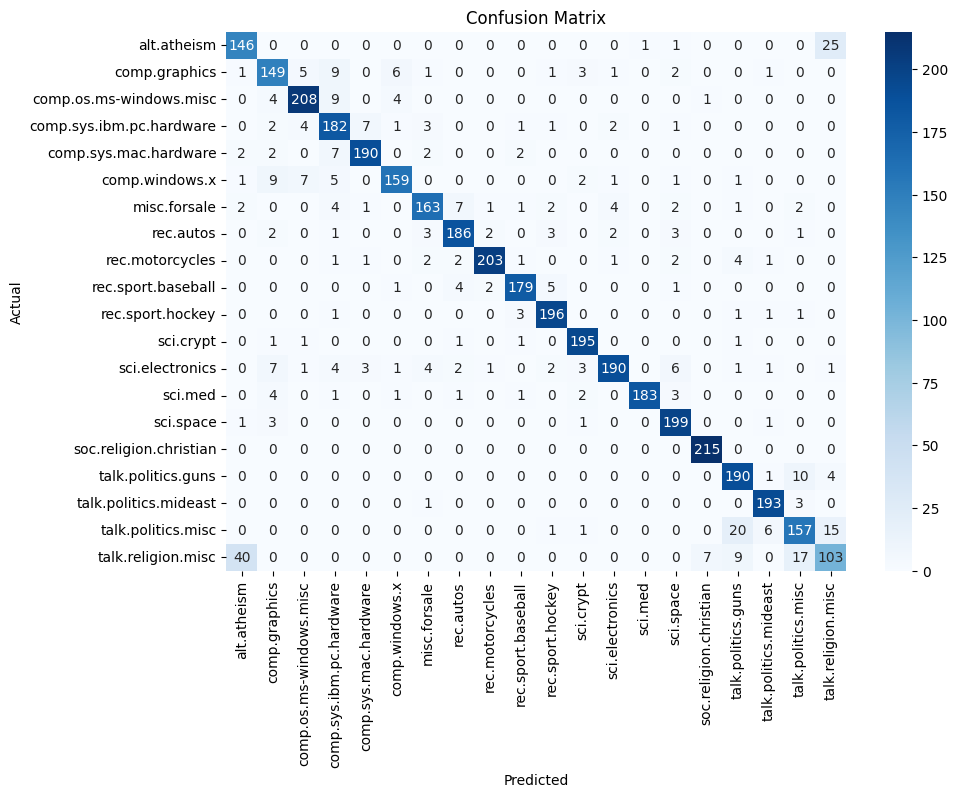

In [40]:
conf_mat = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, 
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Second model - RNN

In [41]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Text processing functions

In [42]:
def preprocess_text(text: str):
    '''
    This function preprocesses the input text by performing the following steps:
    1. Cleans the text by removing all punctuation, numbers, and special symbols.
    2. Converts text to lowercase.

    Parameters
    ----------
    text : (str)
        The input text to be preprocessed.

    Returns
    -------
    (str): The preprocessed text.
    '''
    # Remove punctuation, numbers, and special symbols
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

### Data importing function

In [43]:
def load_data_from_folder(folder_path):
    '''
    This function loads text data from a folder where each subfolder represents a category.
    Each subfolder contains text files corresponding to that category.

    Parameters
    ----------
    folder_path : (str)
        The path to the folder containing the dataset.

    Returns
    -------
    data : (list)
        A list of texts.
    target : (list)
        A list of labels corresponding to each text.
    target_names : (list)
        A list of category names.
    '''
    data = []
    target = []
    target_names = os.listdir(folder_path)
    target_names.sort()  # Sort to ensure consistent order of labels
    label_map = {name: idx for idx, name in enumerate(target_names)}

    for category in target_names:
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for file_name in os.listdir(category_path):
                file_path = os.path.join(category_path, file_name)
                if os.path.isfile(file_path):
                    with open(file_path, 'r', encoding='latin1') as file:
                        text = file.read()
                        text = preprocess_text(text)  # Preprocess the text
                        data.append(text)
                        target.append(label_map[category])

    return data, target, target_names

### Data import and train - test split

In [44]:
folder_path = '../datasets/20_newsgroups'

X, y, target_names = load_data_from_folder(folder_path)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Tokenization

In [45]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [27]:
max_sequence_length = 1000
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

### Converting into Numpy arrays

In [46]:
X_train_pad = np.array(X_train_pad)
X_test_pad = np.array(X_test_pad)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Shape of X_train_pad:", X_train_pad.shape)
print("Shape of X_test_pad:", X_test_pad.shape)

print("Shape of y_train:", np.array(y_train).shape)
print("Shape of y_test:", np.array(y_test).shape)

print("Data type of X_train_pad:", X_train_pad.dtype)
print("Data type of X_test_pad:", X_test_pad.dtype)
print("Data type of y_train:", y_train.dtype)
print("Data type of y_test:", y_test.dtype)


Shape of X_train_pad: (15997, 1000)
Shape of X_test_pad: (4000, 1000)
Shape of y_train: (15997,)
Shape of y_test: (4000,)
Data type of X_train_pad: int32
Data type of X_test_pad: int32
Data type of y_train: int64
Data type of y_test: int64


In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(len(target_names), activation='softmax')
])

In [48]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=4, 
                               mode='min', 
                               verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              min_lr=0.001, 
                              mode='min', 
                              verbose=1)

checkpoint = ModelCheckpoint('classification_model.keras', 
                             monitor='val_loss', 
                             mode='min', 
                             save_best_only=True,
                             verbose=1)

callbacks = [early_stopping, reduce_lr, checkpoint]

callbacks = [early_stopping, reduce_lr]

### Model training

In [49]:
history = model.fit(X_train_pad, y_train, epochs=9, batch_size=64, validation_data=(X_test_pad, y_test), callbacks=callbacks)

Epoch 1/9
250/250 [==============================] - 226s 892ms/step - loss: 2.6234 - accuracy: 0.1553 - val_loss: 2.1666 - val_accuracy: 0.2952 - lr: 0.0010
Epoch 2/9
250/250 [==============================] - 237s 950ms/step - loss: 2.0713 - accuracy: 0.3514 - val_loss: 1.9729 - val_accuracy: 0.3957 - lr: 0.0010
Epoch 3/9
250/250 [==============================] - 282s 1s/step - loss: 1.4113 - accuracy: 0.5769 - val_loss: 1.5417 - val_accuracy: 0.4825 - lr: 0.0010
Epoch 4/9
  4/250 [..............................] - ETA: 6:02 - loss: 1.1170 - accuracy: 0.6641

KeyboardInterrupt: 

### Evaluation

In [ ]:
y_pred = np.argmax(model.predict(X_test_pad), axis=-1)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend(loc='lower right')
plt.show()